In [1]:
# standard library imports
import re
import pickle

# third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

In [2]:
dataset = pd.read_csv("../data/data_enriched.csv")

In [3]:
dataset.head()

,car_color,fuel_type,car_type,car_license,gear_type,windows,motor_power,speedometer,passengers_number,payment_method,car_state,ex_owners,additions,price
0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,75000,4+1,نقدا فقط,للبيع فقط,يد اولى,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,100000
1,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500,130000,7+1,إمكانية التقسيط,للبيع أو التبديل,2,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,60000
2,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,NaN,NaN,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,43500
3,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906,شغال,4+1,إمكانية التقسيط,للبيع فقط,00,\n\nمُكيّف\nمسجل CD\n\n,5500
4,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200,38000,4+1,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغن...,54000


### EDA

In [7]:
# shape of the data
dataset.shape

(6864, 14)

In [8]:
# information about the data
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6864 entries, 0 to 6863
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   car_color          6864 non-null   object
 1   fuel_type          6864 non-null   object
 2   car_type           6864 non-null   object
 3   car_license        6864 non-null   object
 4   gear_type          6864 non-null   object
 5   windows            6864 non-null   object
 6   motor_power        6864 non-null   int64 
 7   speedometer        4923 non-null   object
 8   passengers_number  6087 non-null   object
 9   payment_method     6864 non-null   object
 10  car_state          6864 non-null   object
 11  ex_owners          5214 non-null   object
 12  additions          6864 non-null   object
 13  price              6864 non-null   int64 
dtypes: int64(2), object(12)
memory usage: 750.9+ KB


* Observe that 'speedometer', 'passengers_number', and 'ex_owners' have Null values
* Observe as well that these 3 features are numerics, but here presented as object type, need to handle them 

In [9]:
# Observe null values proportion for each feature
dataset.isnull().mean().\
    sort_values(ascending=False).head()

speedometer          0.282780
ex_owners            0.240385
passengers_number    0.113199
car_color            0.000000
fuel_type            0.000000
dtype: float64

In [10]:
# description of the data
dataset.describe()

,motor_power,price
count,6864.000000,6864.000000
mean,1740.494755,66933.643211
std,589.470714,57022.973482
min,106.000000,1111.000000
25%,1400.000000,36000.000000
50%,1600.000000,55000.000000
75%,2000.000000,83000.000000
max,9000.000000,999999.000000


In [17]:
numeric_parameters_header = dataset.select_dtypes('number').columns
numeric_parameters_header

Index(['motor_power', 'price'], dtype='object')

In [11]:
categorical_data = dataset.select_dtypes(['object'])
categorical_data.describe() # dataset.describe(exclude=[np.number])

,car_color,fuel_type,car_type,car_license,gear_type,windows,speedometer,passengers_number,payment_method,car_state,ex_owners,additions
count,6864,6864,6864,6864,6864,6864,4923,6087,6864,6864,5214,6864
unique,26,4,6,2,3,2,1261,43,2,3,360,196
top,أبيض,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,100000,4+1,نقدا فقط,للبيع فقط,يد اولى,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...
freq,1446,3970,5833,6789,3623,6338,107,4847,4323,4209,505,1254


* Observe having numeric features stored as string.... need to be handled

In [12]:
dataset['passengers_number'].unique()

array(['4+1 ', '7+1 ', nan, '4+1  ', '5+1 ', '٤+١ ', '8 ', '6+1 ', '4+١ ',
       '٧ ', '7,+ 1 ', '7:1 ', '1+7 ', '١+٤ ', '2+1 ', '6+١ ', '+1 ',
       '6±١ ', '22 ', '1+1 ', '٥+١ ', '٧+1 ', '5+2 ', 'مثال: 4 + 1 ',
       '7.1 ', '7 =1 ', '٧+١ ', '1+2 ', '6x1     ', '1+٤ ', '4+1   ',
       '2/1 ', '8+1 ', '٨+١ ', '٦+١ ', '2 ', '4+2 ', '1٠4 ', '4\\١ ',
       '000 ', '3+1 ', '1 ', 'اكثر من 10 ', '9+1 '], dtype=object)

* Observe that this feature have inconsistent data need to be handled

In [13]:
dataset['payment_method'].value_counts()

نقدا فقط            4323
إمكانية التقسيط     2541
Name: payment_method, dtype: int64

In [14]:
dataset['car_type'].value_counts()

خصوصي           5833
عمومي            580
تجاري            189
تأجير            128
حكومي             96
تدريب سياقة       38
Name: car_type, dtype: int64

In [15]:
dataset['car_license'].value_counts()

فلسطينية       6789
نمرة صفراء       75
Name: car_license, dtype: int64

In [16]:
dataset['gear_type'].value_counts()

اوتوماتيك         3623
عادي              3061
نصف اوتوماتيك      180
Name: gear_type, dtype: int64

In [19]:
for feature in dataset:
    print(f'Feature: {feature}\n{dataset[feature].nunique()}: {dataset[feature].unique()}\n')

Feature: car_color
26: ['أبيض عاجي ' 'سكني ' 'بيج ' 'فضي ' 'أسود ' 'بترولي ' 'أبيض '
 'أسود ميتالك ' 'ذهبي ' 'فيراني ' 'أحمر ' 'أزرق ' 'أزرق سماوي ' 'رمادي '
 'عدة الوان ' 'رصاصي ' 'برتقالي ' 'أخضر ' 'بني ' 'خمري ' 'كحلي ' 'زيتي '
 'بنفسجي ' 'جيشي ' 'أصفر ' 'كرميدي ']

Feature: fuel_type
4: ['بنزين ' 'ديزل ' 'هايبرد ' 'كهرباء ']

Feature: car_type
6: ['خصوصي ' 'عمومي ' 'تأجير ' 'تجاري ' 'تدريب سياقة ' 'حكومي ']

Feature: car_license
2: ['فلسطينية ' 'نمرة صفراء ']

Feature: gear_type
3: ['اوتوماتيك ' 'نصف اوتوماتيك ' 'عادي ']

Feature: windows
2: ['الكتروني ' 'يدوي ']

Feature: motor_power
144: [2000 2500 1600  906 1200 1400 4500 1800 2200 1250 1300 1500 1100 3700
 1235 1900 2400 1000  125  800  220  420 1999 3600 3000 1850 4800  200
 3100 2300 3500 1150 3200 4000  300 2800  390 1995  900 1990 2008 2700
 5985 2900  903 1595 7000  250  270 6500 1499  550 2600 1950 1350  240
 3222 1690  170 1009 9000  230  905 3300  460 2996 5983  160  260 1700
  340 1234  180 5800 1190 1498 4750  210 198

In [20]:
dict_features_unique_values = {}
for feature in dataset:
    dict_features_unique_values[feature] = (dataset[feature].nunique(), dataset[feature].unique())
    
dict_features_unique_values

{'car_color': (26,
  array(['أبيض عاجي ', 'سكني ', 'بيج ', 'فضي ', 'أسود ', 'بترولي ', 'أبيض ',
         'أسود ميتالك ', 'ذهبي ', 'فيراني ', 'أحمر ', 'أزرق ',
         'أزرق سماوي ', 'رمادي ', 'عدة الوان ', 'رصاصي ', 'برتقالي ',
         'أخضر ', 'بني ', 'خمري ', 'كحلي ', 'زيتي ', 'بنفسجي ', 'جيشي ',
         'أصفر ', 'كرميدي '], dtype=object)),
 'fuel_type': (4,
  array(['بنزين ', 'ديزل ', 'هايبرد ', 'كهرباء '], dtype=object)),
 'car_type': (6,
  array(['خصوصي ', 'عمومي ', 'تأجير ', 'تجاري ', 'تدريب سياقة ', 'حكومي '],
        dtype=object)),
 'car_license': (2, array(['فلسطينية ', 'نمرة صفراء '], dtype=object)),
 'gear_type': (3,
  array(['اوتوماتيك ', 'نصف اوتوماتيك ', 'عادي '], dtype=object)),
 'windows': (2, array(['الكتروني ', 'يدوي '], dtype=object)),
 'motor_power': (144,
  array([2000, 2500, 1600,  906, 1200, 1400, 4500, 1800, 2200, 1250, 1300,
         1500, 1100, 3700, 1235, 1900, 2400, 1000,  125,  800,  220,  420,
         1999, 3600, 3000, 1850, 4800,  200, 3100, 2300, 35

* Observe having plenty inconsistent data in the features needed to be handled

### Data Enriching

##### Handle inconsistent data in 'passengers_number' feature

In [21]:
# Observe number of samples with no '+' sign along with their values
no_sum, no_sum_indices, naan_indices = [], [], []
for indx, car_passengers in enumerate(dataset['passengers_number']):
    if car_passengers is np.nan:
        naan_indices.append(indx)
    elif '+' not in car_passengers and not car_passengers.strip().isdigit():
        no_sum_indices.append(indx)
        no_sum.append((indx, car_passengers))

In [22]:
print(no_sum_indices, end='')

[51, 157, 335, 391, 462, 576, 704, 1304, 1692, 4016, 4189, 4661, 5029, 5296, 5776, 5806]

In [23]:
print(len(no_sum))
print(no_sum, end='')

16
[(51, '7:1 '), (157, '6±١ '), (335, '7.1 '), (391, '7 =1 '), (462, '6x1     '), (576, '2/1 '), (704, '4\\١ '), (1304, 'اكثر من 10 '), (1692, 'اكثر من 10 '), (4016, 'اكثر من 10 '), (4189, 'اكثر من 10 '), (4661, 'اكثر من 10 '), (5029, 'اكثر من 10 '), (5296, 'اكثر من 10 '), (5776, 'اكثر من 10 '), (5806, 'اكثر من 10 ')]

In [24]:
len(naan_indices)

777

In [25]:
def enrich_passengers_number(data):
    for indx, car_passengers in enumerate(data['passengers_number']):
        if (car_passengers is not np.nan):
            if ('+' in car_passengers):
                # split the sample based on '+' sign 
                car_passengers_number = car_passengers.split('+')
                sum = 0
                # if the values resulted from the split ae digits, then sum them
                for val in car_passengers_number:
                    val = val.strip(" ,")
                    if val.isdigit():
                        sum += int(val)
                # change the value of that sample to be equal digits summation
                data['passengers_number'].iloc[indx] = sum
            # if the sample contains only a number, then just typecast it after stripping
            elif car_passengers.strip().isdigit():
                data['passengers_number'].iloc[indx] = int(car_passengers.strip())
            else:
                data['passengers_number'].iloc[indx] = np.nan

    data['passengers_number'] = data['passengers_number'].astype(float)
    return data

In [26]:
dataset = enrich_passengers_number(dataset)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\4198106469.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['passengers_number'].iloc[indx] = sum
C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\4198106469.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['passengers_number'].iloc[indx] = int(car_passengers.strip())
C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\4198106469.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

##### Handle inconsistent data in 'ex_owners' feature

In [27]:
(dataset['ex_owners'].nunique(), dataset['ex_owners'].unique())

(360,
 array(['يد اولى ', '2 ', nan, '00  ', '0 ', '1 ', 'يد ثانية ', '4 ',
        'يد ثانيه ', '3 ', 'ثالثة ', 'غير منمر استيراد الماني ', '00 ',
        'غير منمرة ', 'أولى ', '٨ ', 'يد اولا ', 'يد ثالثة ', 'يد ثالثة  ',
        'ثانية ', 'يد أولى ', 'يد سادسة ', '5 ', 'اولى  ', 'صفر ', '9 ',
        '0000 ', 'رابعه ', 'يد أولى  ', '٤ ', 'يد رابعة  ', '٢ ',
        'يد ثالثه ', '6 ', 'يد اولى  ', '7 ', '... ', 'يد ثانيه  ',
        'يد أولى استيراد ', 'يد اولي 1 ', 'اولى ', '...... ', 'ثانيه ',
        'واحد ', 'اربعة ', 'اولا ', '٣ ', 'غير منمره ', 'يد تالته ', '٦ ',
        'يد رابعه ', 'يد ثالثة ( فتيات) ', '159000 ', '12 ', '- ',
        'مش منمر ', '0 مستورده ', 'يد تانيه ', '10 ', 'يد 1 ', 'مستورد ',
        'يد 4 ', 'يد رابعة ', '00000 ', '١ ', 'استيراد مباشر من كوريا  ',
        'يد خامسة ', '٥ ', 'يد 5 ', '******** ', 'نعم ', 'مش منمرة  ',
        'يد 3 ', ' يد ثانيه ', 'يداولى ', '4  ', 'يد أولى وكالة ',
        'يد خامسه ', 'يد ثانية  ', '٩ ', '٧ ', 'يدو اولى ', 'للبيع  '

In [28]:
def handle_inconsistent_ex_owners(data):
       pre_drivers_0 = ['00  ', '0 ', '00 ', 'صفر ', '0000 ', '00000 ', '0 مستورده ', '0مستورد ', 
       'يد صفر  ', 'يد صفر ', '0استيراد  ', '000000 ', 'اصحاب سابقون صفر ', '000 ', 
       'صفر  ', 'صفرض ', '0 مستورد كوري ', '00000000 ', 'يد أولئ ex_owners صفر ', 
       'يد 0 ', 'صفرر ', '، 0 ', ' 0 ', '0 استيراد كوري  ', '0000000 ', ' 00 ', 'مش منمر . (صفر) ', 
       '0 استيراد  ', '٠ ', '٠٠٠٠ ', '٠٠٠٠٠٠٠٠٠ ', '٠٠٠٠٠٠ ', '٠٠٠٠٠٠٠٠٠٠ ', '٠٠ ','٠٠٠٠٠٠٠٠ ' ,
       '٠٠٠٠٠ ', '٠٠٠٠٠٠٠ ', '... ', '...... ', '......... ', 'Zero ', 'لا يوجد ', '. ', 'لايوجد ', 
       '.... ', 'من الشركه مباشر لا يوجد اصحاب سابقون ', 'Ooo ', 'استيراد كوريا - جديد مش منمر ', 
       '  O ',  '.. ', 'لا شيء ', 'O '
       ]

       pre_drivers_1 = ['1 ', 'يد اولى ', 1, 'يد. اولى', 'واحد ', 'اولا ', '١ ',
       'أولى ', 'يد أولى ', 'اولى  ', 'يد أولى  ', 'يد اولى  ', 'يد أولى استيراد ', 'يد اولي 1 ', 'اولى ', 'يد 1 ', 'يداولى ', 'يد أولى وكالة ', 'يدو اولى ', 'يد اولى شركة ', 
       'يد. اولى ', 'ياولى ', 'يد اولى وكالة ', 'يد اولى  اصل شركة ', 'يد اولى اصحاب سابقون 0 ', 'أولى  ', 'وارد كوريا يد اولى ', 'يد اولى صفر كيلو  ', 'مستورده يد اولى ', 
       'ايد اولى ', '1  ', 'يد أولى بعد الاستيراد ', 'يد أولى 1 ', 'ايد اولى  ', ' 1 ', 'يد اولى فقط ', 'يد أولى،... ', 'اولى\x89 ', 'فقط يد اولى ', 'يد اولى، استيراد شخصي ', 
       'يدو اولى  ', 'يد اولى ( شركة ) ', 'يدأولى ', 'يداولى سحب شركه ', 'يد اولى استيراد شخصي ', 'ايد أولى  ', '01 ', 'يد اولى الماني  ', 'يد اولىً ', 'يد اولى / استيراد ', 
       '1 أولى  ', 'مستوردة يد اولى ', 'بد اولى مستورد ', 'يد اولى من الشركة المتحدة ',
       'يد اولا ', 'يداولا ', 'يد اولا  ', 'يد ١ ', 'يد  ١ ', 'يد واحد  ', '11111 ', 'يد واله ', 'يد اولئ ', 'يد اولي', 'ايد اوله ', 'يد اولة  ', 
       'اوله  ', 'يد اول',  'يدى اوله  ', 'يد اولي  ', 'اول ', 'يد ولا ', 'يد اول  ', 'يد اولي ', 'اوله ', 'يد ولى ', 'يد أولي ', 'يد اول ', 
       'يد أولئ  ', 'يد ا ', 'يد اوله ', 'يد واحدة  ', 'يد ', 'يد اولة ',  '4 نفس الشخص ', 'يد اةلي ', 'أولئ', 'يد أولئ أصحاب سابقون صفر '
       ]

       pre_drivers_2 = ['2 ', 'يد ثانية ', 'يد ثانيه ', 'ثانية ', '٢ ', 'يد ثانيه  ', 'ثانيه ', 'يد تانيه ', ' يد ثانيه ', 
       'يد ثانية  ', '2  ', 'يد 2 ', 'يدثانيه  ', 'ايد ثانيه ', 'يد ٢ ', ' يد ثانية ', 'يدثانيه ', 'يد تانية ', 
       'ايد 2 ', ' 2 ', 'أيد تانية ', 'يدثانية ', 'تانيه ', '2يد  ', 'يدتانيه ', 'ثانية  ', 'ايد ثانية  ', '2يد ', 
       'يد٢ ', 'يد2 ', 'ايدثانيه ', 'يد  ثانية ', 'يد تانيه  ', 'تانية ', 'الثانية ', 'يد تانية  ', '@ ',
       'اثنان ', 'يد تاني ', 'يد ثني ', 'يد ثاتيه ', 'يد ثاني ', 'ثانبه ', 'يد ثاني.  ', 'تانبه ', 'يد ثانيا ', 
       'تاني  ', 'ثاني ', 'يديانيه ', 'يد ثاني  ',
       ]

       pre_drivers_3 = ['3 ', 'ثالثة ', 'يد ثالثة ', 'يد ثالثة  ', 'يد ثالثه ', '٣ ', 'يد تالته ', 'يد ثالثة ( فتيات) ', 
              'يد 3 ', 'ثالثه ', '03 ', 'ثالثة  ', '13 ', 'يد ثالثه  ', 'يد3 ', 'يدثالثة ', 'عدد٣ ', 'تالته ', 
              'يد ٣ ', 'يدثالثه ', 'يد٣ ', 'يد التالته ', ' ايد ثالثه ', 'تالثه ', '3  ', ',3 ', 'ايد ثالثة  ', 'ايد 3 ',
              'يد ثالث ', 'ثالث ', 'ثالثى ',  'يد ثالثي ',
              ]

       pre_drivers_4 = ['4 ', 'رابعه ', '٤ ', 'يد رابعة  ', 'اربعة ', 'يد رابعه ', 'يد 4 ', 'يد رابعة ', '4  ', 'رابعة ', 
              'يد4 ', 'يد ٤ بس نخب السيارة ', 'يد ٤ ', 'يد٤ ', 'يد رابعه  ', 'ايد رابعه ', '14 ', '04 ', 'يد اربعه ', 
              'رابعه  ', '٤٤٤٤٤ ']

       pre_drivers_5 = ['5 ', 'يد خامسة ', '٥ ', 'يد 5 ', 'يد خامسه ', 'يد خامسة  ', ' 5 ', 'يدخامسه ', 'خامسة ', 
                     'يد٥ ', 'خامسه ', 'يد ٥ ', '  5 ', 'يد خامساً  ', 'يد خمسة ', 'خمسه ', 'خمسة ', 'خمس ', ]

       pre_drivers_6 = ['يد سادسة ', '6 ', '٦ ', 'يد6 ', '  6 ', 'يد 6 ']

       pre_drivers_7 = ['7 ', '٧ ', 'يد سابعة ', 'يد سابعه ', 'يد ٧  ', 'سابعه ']

       pre_drivers_8 = ['٨ ', '8 ', '١٨ ', 'يد ثامنه ', 'يد 8 ', 'ثمانيه ']

       pre_drivers_9 = ['9 ', '٩ ', '٠٠٠٠٩ ', 'يد ٩  ', 'يد تاسعة ']

       pre_drivers_10 = ['10 ', '١٠ ', 'يد عاشره ', 'يد عاشرة ']

       pre_drivers_11 = ['11 ', '١١ ']


       pre_drivers_12 = ['12 ', '١٢ ']
       pre_drivers_15 = ['١٥ ', '15 ']
       pre_drivers_16 = ['16 ']
       pre_drivers_17 = ['17 ', 'يد ١٧ ', '١٧ ', '١٧', '١٧ ', '١٧ ', 'يد ١٧ ',
                     '17 ', 'يد ١٧ ' , '١٧ ', 'يد ١٧ ', '١٧ '
                     ]
       pre_drivers_18 = ['18 ']
       pre_drivers_19 = ['19 ']

       pre_drivers_importation = ['مستورد شركة  ', 'استيراد الماني ', ' استيراد الماني ', 'مستورد ', 'استيراد مباشر من كوريا  ', 
                                   'استيراد كوري ', 'مستوردة ', 'استيراد ', 'استيراد كوريا ', 'استيراد مباشر من اوروبا  ', 
                                   'وارد المانيا ', 'استراد  ', 'استيراد المانيا ', 'استيراد كوريا  ', 'مستورده  ', 'مستوردة  ',  'أستيراد ألماني  ', 
                                   'مستوردة غير مرخصة ', 'استراد شخصي ',
                                   'مستورد  ', 'مستورده ', 'استيراد مباشر ', 
                                   ]

       car_no_number = ['غير منمر استيراد الماني ', 'غير منمرة ', 'غير منمره ', 'مش منمر ', 'مش منمرة  ', 'مش منمرة ', 
                     'غير منمر  ', 'مستود غير منمر ', 'مش منمرا ', 'غير منمرة  ', 'غير منمر ', 'مش منمر  ', 'غير منمرمستوردة ',
                     'مستوردة غير منمرة ', 'مش منمره '
                     ]
       pre_drivers_yes_no_number = ['نعم ', ' منمره  ']

       null_values = ['- ', '******** ', 'ا ', '********** ', '****** ', '--- ', '؟ ', '? ', 'E ', '، ', 
                     'للبيع  ', 'اصل تدريب سواقه  ', 'انا ', 'سحب شركة ', 'شطب ', 'اصل شركة ', 'مشطوب ', 'خصوصي  '
                     ]
       large_num = ['159000 ', '56 ', '170000 ', '78888877766 ', '0778244 ', '1000 ', '123423 ', '12345 ', 'اشخاص ']

       pre_drivers = [pre_drivers_0, pre_drivers_1, pre_drivers_2, pre_drivers_3, pre_drivers_4, 
                     pre_drivers_5, pre_drivers_6, pre_drivers_7, pre_drivers_8,pre_drivers_9, 
                     pre_drivers_10, pre_drivers_11, pre_drivers_12, pre_drivers_15, pre_drivers_16, 
                     pre_drivers_17, pre_drivers_18, pre_drivers_19, null_values, car_no_number,
                     pre_drivers_yes_no_number, large_num, pre_drivers_importation
                     ]


       dict_pre_drivers = {
              **dict.fromkeys(pre_drivers_0, 0), 
              **dict.fromkeys(car_no_number, 0), 
              **dict.fromkeys(pre_drivers_yes_no_number, 0), 
              **dict.fromkeys(pre_drivers_importation, 0),
              **dict.fromkeys(pre_drivers_1, 1), 
              **dict.fromkeys(pre_drivers_2, 2), 
              **dict.fromkeys(pre_drivers_3, 3), 
              **dict.fromkeys(pre_drivers_4, 4), 
              **dict.fromkeys(pre_drivers_5, 5), 
              **dict.fromkeys(pre_drivers_6, 6), 
              **dict.fromkeys(pre_drivers_7, 7), 
              **dict.fromkeys(pre_drivers_8, 8), 
              **dict.fromkeys(pre_drivers_9, 9), 
              **dict.fromkeys(pre_drivers_10, 10), 
              **dict.fromkeys(pre_drivers_11, 11), 
              **dict.fromkeys(pre_drivers_12, 12), 
              **dict.fromkeys(pre_drivers_15, 15), 
              **dict.fromkeys(pre_drivers_16, 16),
              **dict.fromkeys(pre_drivers_17, 17),
              **dict.fromkeys(pre_drivers_18, 18), 
              **dict.fromkeys(pre_drivers_19, 19),
              **dict.fromkeys(null_values, np.NaN), 
              **dict.fromkeys(large_num, np.NaN), 
              }

       data['ex_owners'].replace(dict_pre_drivers, inplace=True)
       

       return data #.astype(float)


In [29]:
handle_inconsistent_ex_owners(dataset)

,car_color,fuel_type,car_type,car_license,gear_type,windows,motor_power,speedometer,passengers_number,payment_method,car_state,ex_owners,additions,price
0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,75000,5.0,نقدا فقط,للبيع فقط,1.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,100000
1,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500,130000,8.0,إمكانية التقسيط,للبيع أو التبديل,2.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,60000
2,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,NaN,NaN,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,43500
3,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906,شغال,5.0,إمكانية التقسيط,للبيع فقط,0.0,\n\nمُكيّف\nمسجل CD\n\n,5500
4,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200,38000,5.0,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغن...,54000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000,130000,5.0,إمكانية التقسيط,للبيع فقط,2.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغن...,45000
6860,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400,00000,8.0,نقدا فقط,للبيع فقط,5.0,\n\n\n,48000
6861,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600,50000,5.0,نقدا فقط,للبيع فقط,0.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,87000
6862,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200,100,7.0,نقدا فقط,للبيع فقط,2.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,126000


In [30]:
dataset['ex_owners']

0       1.0
1       2.0
2       NaN
3       0.0
4       NaN
       ... 
6859    2.0
6860    5.0
6861    0.0
6862    2.0
6863    5.0
Name: ex_owners, Length: 6864, dtype: float64

* And now 'ex_owners' is handled and all samples are from type float

In [31]:
print(f"{dataset['ex_owners'].nunique()} => {dataset['ex_owners'].unique()}")

18 => [ 1.  2. nan  0.  4.  3.  8.  6.  5.  9.  7. 12. 10. 11. 16. 17. 15. 18.
 19.]


##### Handle inconsistent and duplicated data in 'speedometer' feature

In [32]:
print(f"Feature: 'speedometer']\n{dataset['speedometer'].nunique()}: {dataset['speedometer'].unique()}\n")

Feature: 'speedometer']
1261: ['75000 ' '130000 ' nan ... '222222 ' '177 ' '7686866 ']



In [33]:
list_thousand = []
for indx, val in enumerate(dataset['speedometer']):
    if val is not np.nan:
        if 'ال' in val:
            list_thousand.append((indx, val))


In [34]:
print(list_thousand, end='')

[(3, 'شغال '), (17, '150 الف  '), (84, '80 الف '), (101, '120 الف '), (182, '60الف '), (208, '47 الف '), (254, 'شغال '), (271, '140 الف كيلو متر  '), (331, 'شغال '), (360, '40 الف '), (421, '80الف '), (444, 'شغال '), (507, '91 الف '), (594, '150 الف '), (639, 'شغال '), (643, 'شغال '), (662, '60 الف كيلو متر '), (682, '27الف كيلو '), (694, '78 الف '), (702, '١٤٣ الف '), (721, '100 الف كيلو '), (723, '230 الف كيلو متر  '), (839, '112 الف كيلو '), (894, 'شغال  '), (905, '٧٠٠٠٠ الف كيلو '), (948, '92الف كيلو '), (1024, '٣٥ الف كيلو '), (1039, '100الف '), (1158, '٢١٠ الاف '), (1159, '47 الف  '), (1173, '350 الف  '), (1189, '140 الف '), (1197, '90000الف فقط '), (1280, '١٩ الف سنويا '), (1348, '٩٨ الف '), (1467, '39000الف كيلو متر  '), (1505, '٣٠٠ الف '), (1561, '42 الف '), (1610, 'شغال  '), (1771, '65 الف  '), (1791, '٧٠ الف  '), (1821, '91 الف كم '), (1852, '100 الف '), (1872, '95  الف  '), (1874, '130 الف '), (1990, '130الف '), (1993, 'ماشيه 80الف كم  '), (1996, '190الف '), (2003, '15 الف 

replace 'الف' and 'الاف' with '000'

In [35]:
def handle_inconsistent_speedometer(data):
    for indx, sample in enumerate(data['speedometer']):
        if sample is not np.nan:
            if 'الف' in sample or 'الاف' in sample:
                sample = sample.replace('الف', '000')
                sample = sample.replace('الاف', '000')
            if sample.strip().isdigit():
                    data['speedometer'].iloc[indx] = int(sample.strip())
            extract_num = re.sub(r'[^0-9]', '', sample)
            if extract_num.isdigit():
                data['speedometer'].iloc[indx] = int(extract_num)
            if isinstance(data['speedometer'].iloc[indx], str):
                data['speedometer'].iloc[indx] = np.nan
    return data

In [36]:
handle_inconsistent_speedometer(dataset)

C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\4219534348.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['speedometer'].iloc[indx] = int(sample.strip())
C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\4219534348.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['speedometer'].iloc[indx] = int(extract_num)
C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\4219534348.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,car_color,fuel_type,car_type,car_license,gear_type,windows,motor_power,speedometer,passengers_number,payment_method,car_state,ex_owners,additions,price
0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,75000,5.0,نقدا فقط,للبيع فقط,1.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,100000
1,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500,130000,8.0,إمكانية التقسيط,للبيع أو التبديل,2.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,60000
2,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,NaN,NaN,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,43500
3,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906,NaN,5.0,إمكانية التقسيط,للبيع فقط,0.0,\n\nمُكيّف\nمسجل CD\n\n,5500
4,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200,38000,5.0,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغن...,54000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6859,فيراني,كهرباء,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1000,130000,5.0,إمكانية التقسيط,للبيع فقط,2.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغن...,45000
6860,أبيض,ديزل,عمومي,فلسطينية,عادي,الكتروني,2400,0,8.0,نقدا فقط,للبيع فقط,5.0,\n\n\n,48000
6861,فضي,ديزل,خصوصي,فلسطينية,عادي,الكتروني,1600,50000,5.0,نقدا فقط,للبيع فقط,0.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,87000
6862,بترولي,ديزل,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2200,100,7.0,نقدا فقط,للبيع فقط,2.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,126000


##### Price distribution of cars

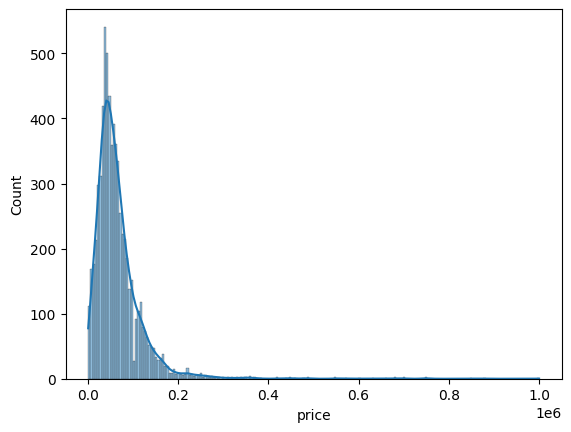

In [37]:
sns.histplot(dataset['price'],kde=True)
plt.show()

* Price distribution plot is right skewed
* maximum number of cars are in range of [0, 180000]

##### Price distribution of diesel vs gas car

In [38]:
dataset['fuel_type'].value_counts()

بنزين      3970
ديزل       2870
هايبرد       23
كهرباء        1
Name: fuel_type, dtype: int64

* Observe having one car sample with كهرباء fuel type, let's depict it

In [39]:
dataset.loc[dataset['fuel_type'] == 'كهرباء']

,car_color,fuel_type,car_type,car_license,gear_type,windows,motor_power,speedometer,passengers_number,payment_method,car_state,ex_owners,additions,price


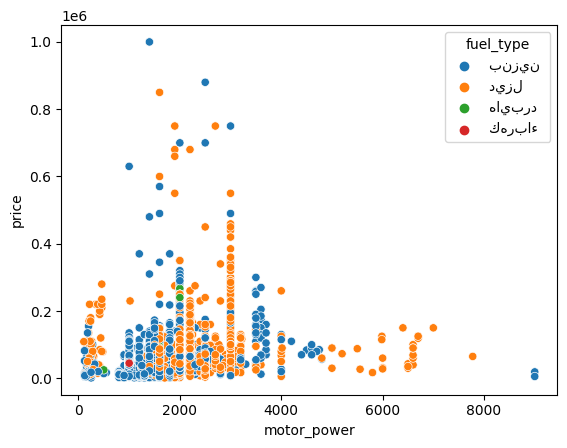

In [40]:
sns.scatterplot(x=dataset['motor_power'], y=dataset.price, hue=dataset['fuel_type'])
plt.show()

* Most of the cars with diesel fuel type range in motor_power between 1800 and 3000
* Cars with كهرباء و هايبرد fuel_type are cheaper than ديزل و بنزين

* It's known that cars with زجاج الكتروني are more expensive than those with زجاج يدوي... Let's check it out 

<AxesSubplot: xlabel='windows', ylabel='price'>

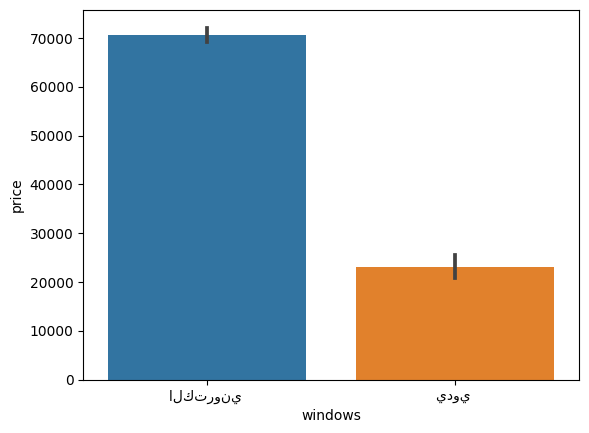

In [41]:
sns.barplot(x=dataset['windows'], y=dataset.price)

In [42]:
dataset['windows'].value_counts()

الكتروني     6338
يدوي          526
Name: windows, dtype: int64

<AxesSubplot: xlabel='windows', ylabel='count'>

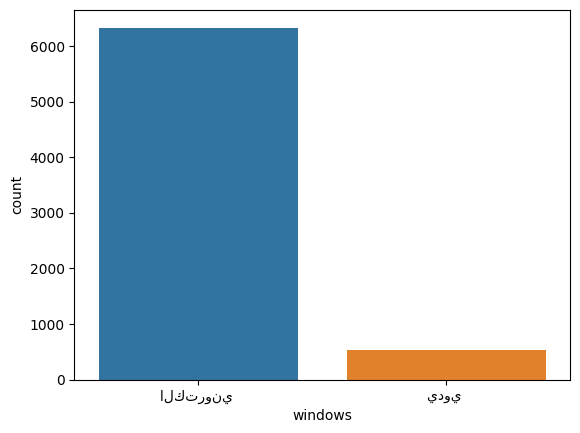

In [43]:
sns.countplot(x = dataset['windows'])

<AxesSubplot: xlabel='windows', ylabel='price'>

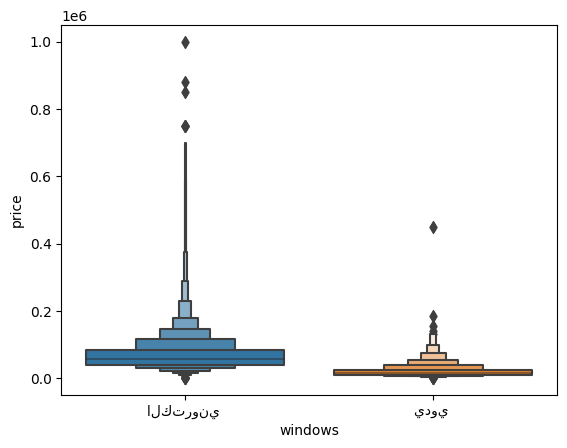

In [44]:
sns.boxenplot(x=dataset['windows'], y=dataset['price'])

* Most of the cars in the dataset with زجاج الكتروني and they're way more expensive
* As depected at the plot, there is a lot of outliers, but may not be indeed outliers, as other features affect the price 

In [45]:
dataset.loc[dataset['windows'] == 'الكتروني'].sort_values('price')

,car_color,fuel_type,car_type,car_license,gear_type,windows,motor_power,speedometer,passengers_number,payment_method,car_state,ex_owners,additions,price


<AxesSubplot: xlabel='fuel_type', ylabel='price'>

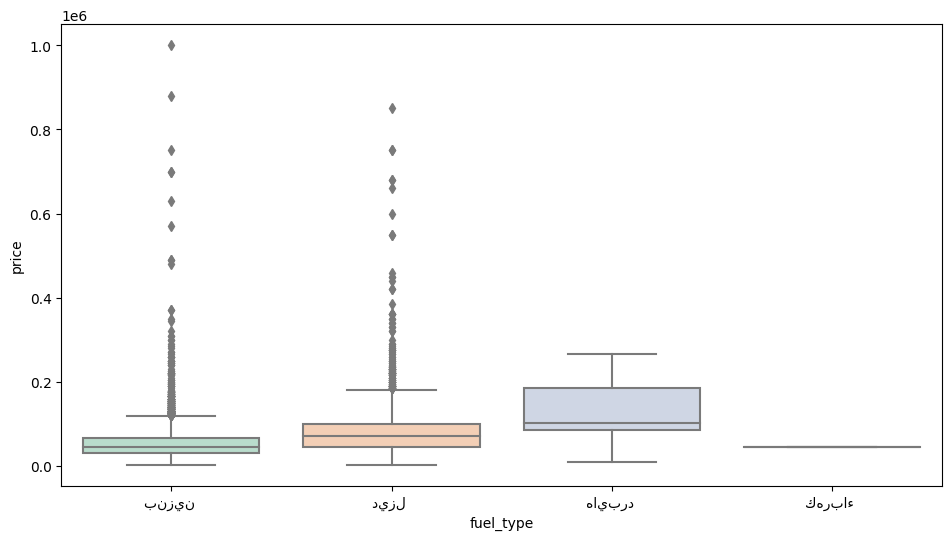

In [46]:
f= plt.figure(figsize=(25,6))
ax=f.add_subplot(121)
sns.boxplot(x = 'fuel_type', y = 'price', data = dataset, palette='Pastel2')

* 'هايبرد' is the most expensive. But we can't take this information for granted, as 'هايبرد' few biased samples
* Price of diesel is much higher than of gas 
* there are some outliers in gas vehicles, will depect car types for outlier samples

##### Depict density for numerical features

C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\130652956.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['passengers_number'], color="dodgerblue", label="Compact")


<AxesSubplot: xlabel='passengers_number', ylabel='Density'>

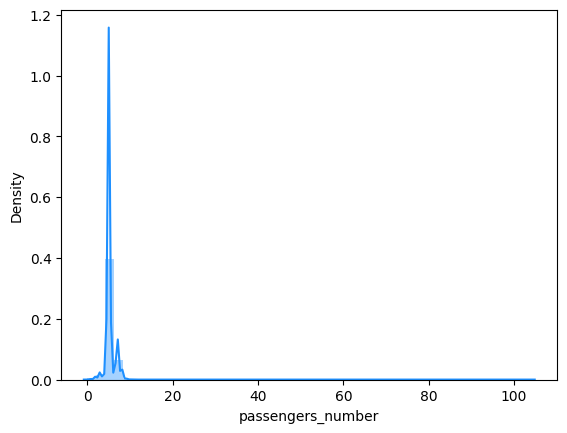

In [49]:
sns.distplot(dataset['passengers_number'], color="dodgerblue", label="Compact")

* Observe most of the values gathered in less than 15 passengers, lets depict them alone, and s=depict the others alone as well

C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\1912573017.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[dataset['passengers_number'] < 15]['passengers_number'], color="dodgerblue", label="Compact")


<AxesSubplot: xlabel='passengers_number', ylabel='Density'>

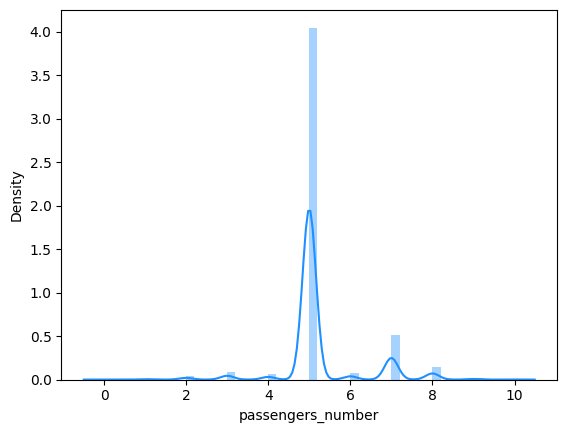

In [50]:
sns.distplot(dataset[dataset['passengers_number'] < 15]['passengers_number'], color="dodgerblue", label="Compact")

C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\1487785270.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset[dataset['passengers_number'] > 15]['passengers_number'], color="dodgerblue", label="Compact")


<AxesSubplot: xlabel='passengers_number', ylabel='Density'>

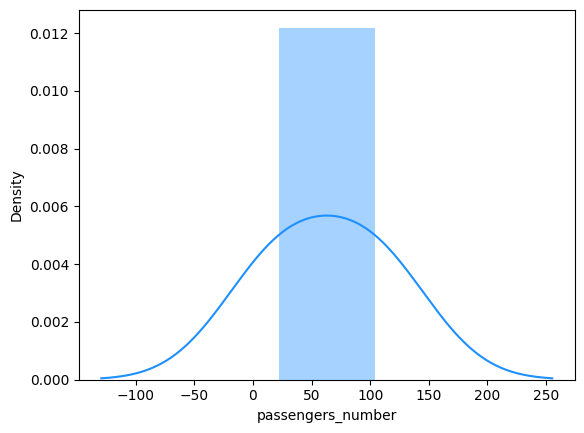

In [51]:
sns.distplot(dataset[dataset['passengers_number'] > 15]['passengers_number'], color="dodgerblue", label="Compact")

In [52]:
# check these outliers with their count
dataset[dataset['passengers_number'] > 15]['passengers_number'].value_counts()

22.0     1
104.0    1
Name: passengers_number, dtype: int64

* won't drop them, as it might be a bus

C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\2115716780.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['motor_power'], label="Compact")


<AxesSubplot: xlabel='motor_power', ylabel='Density'>

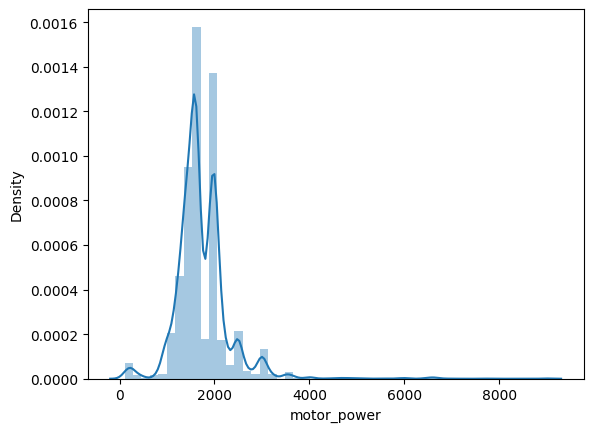

In [53]:
sns.distplot(dataset['motor_power'], label="Compact")

* Normal distribution

C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\4285841550.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['ex_owners'], label="Compact")


<AxesSubplot: xlabel='ex_owners', ylabel='Density'>

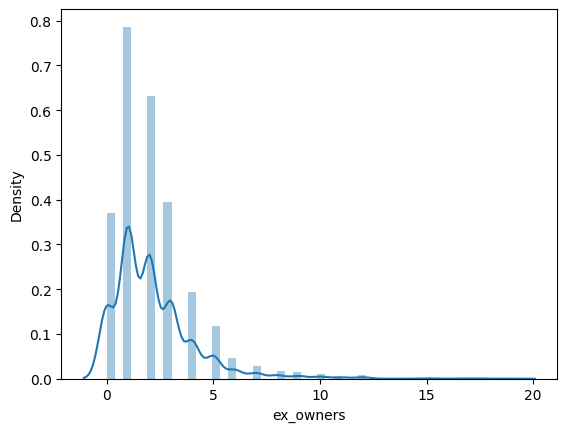

In [54]:
sns.distplot(dataset['ex_owners'], label="Compact")

##### Price distribution according to passengers_number

C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\1332566004.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plot=sns.distplot(dataset[(dataset['passengers_number'] == 2)]["price"],color='#ca91eb',ax=ax)
C:\Users\DELL\AppData\Local\Temp\ipykernel_11324\1332566004.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  plo

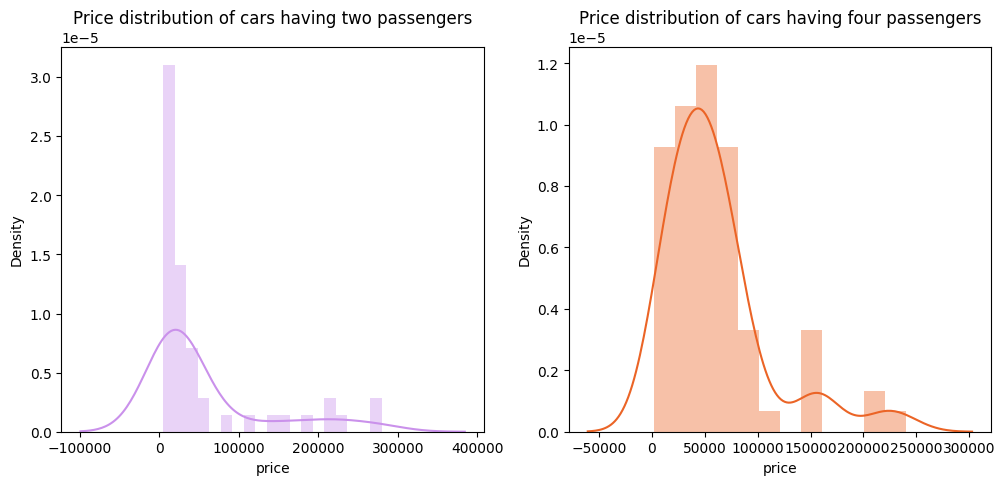

In [55]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
plot=sns.distplot(dataset[(dataset['passengers_number'] == 2)]["price"],color='#ca91eb',ax=ax)
ax.set_title('Price distribution of cars having two passengers')

ax=f.add_subplot(122)
plot=sns.distplot(dataset[(dataset['passengers_number'] == 4)]['price'],color='#eb6426',ax=ax)
ax.set_title('Price distribution of cars having four passengers')

plt.show()

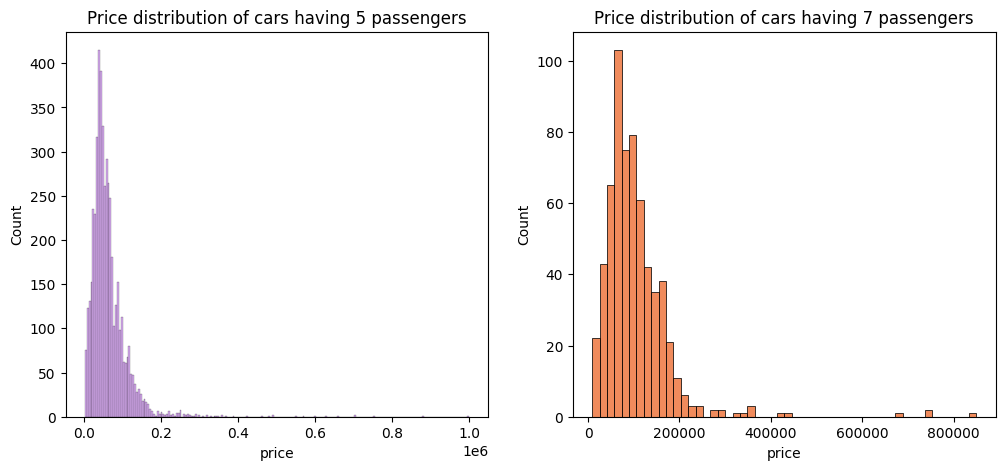

In [56]:
f= plt.figure(figsize=(12,5))

ax=f.add_subplot(121)
plot=sns.histplot(dataset[(dataset['passengers_number'] == 5)]["price"],color='#ca91eb',ax=ax)
ax.set_title('Price distribution of cars having 5 passengers')

ax=f.add_subplot(122)
plot=sns.histplot(dataset[(dataset['passengers_number'] == 7)]['price'],color='#eb6426',ax=ax)
ax.set_title('Price distribution of cars having 7 passengers')

plt.show()

In [57]:
numeric_data = dataset.select_dtypes('number')
numeric_parameters_header = numeric_data.columns
numeric_parameters_header

Index(['motor_power', 'passengers_number', 'ex_owners', 'price'], dtype='object')

<AxesSubplot: >

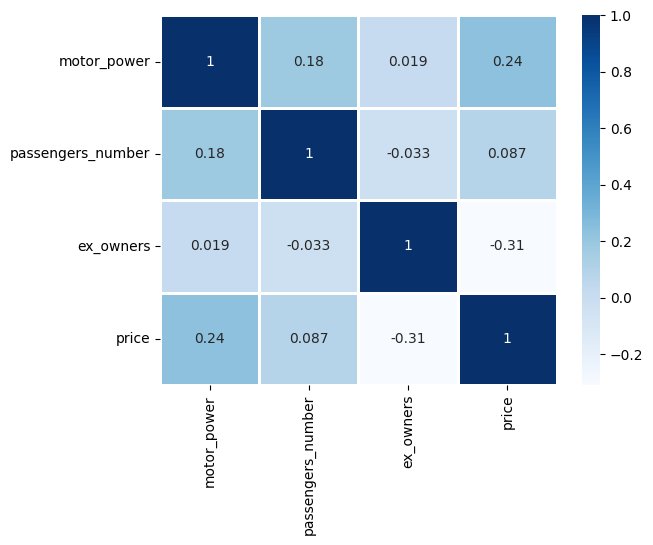

In [58]:
# plt.figure(figsize=(20,15))
corr = numeric_data.corr() #.abs()
sns.heatmap(corr, annot=True, cmap='Blues', linewidth=1)

* ex_owners have the highest correltion with price
* following is motor_power

Text(0, 0.5, 'Frequency')

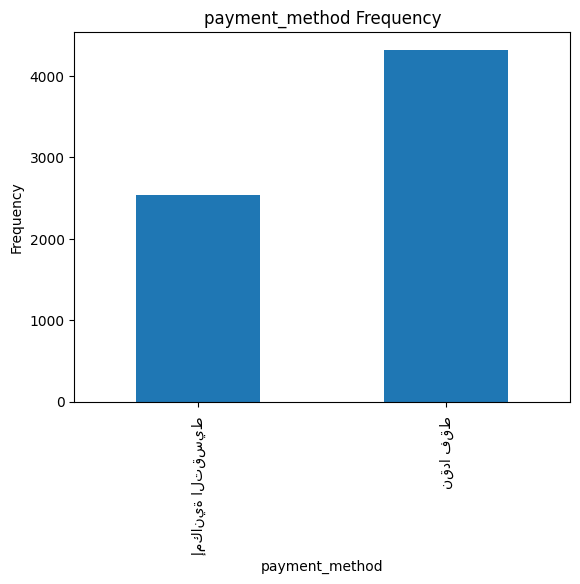

In [59]:
fig, ax = plt.subplots()
ax = dataset['payment_method'].value_counts().sort_index().plot.bar()
# set title and labels 
ax.set_title('payment_method Frequency')
ax.set_xlabel('payment_method') 
ax.set_ylabel('Frequency')

Text(0, 0.5, 'motor power Frequency')

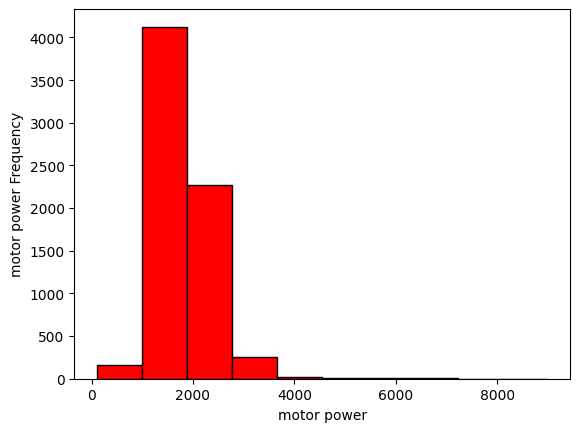

In [60]:
fig, ax = plt.subplots()
ax = dataset['motor_power'].plot.hist(edgecolor="black", color="r")
ax.set_xlabel('motor power')
ax.set_ylabel('motor power Frequency')

<AxesSubplot: xlabel='passengers_number', ylabel='price'>

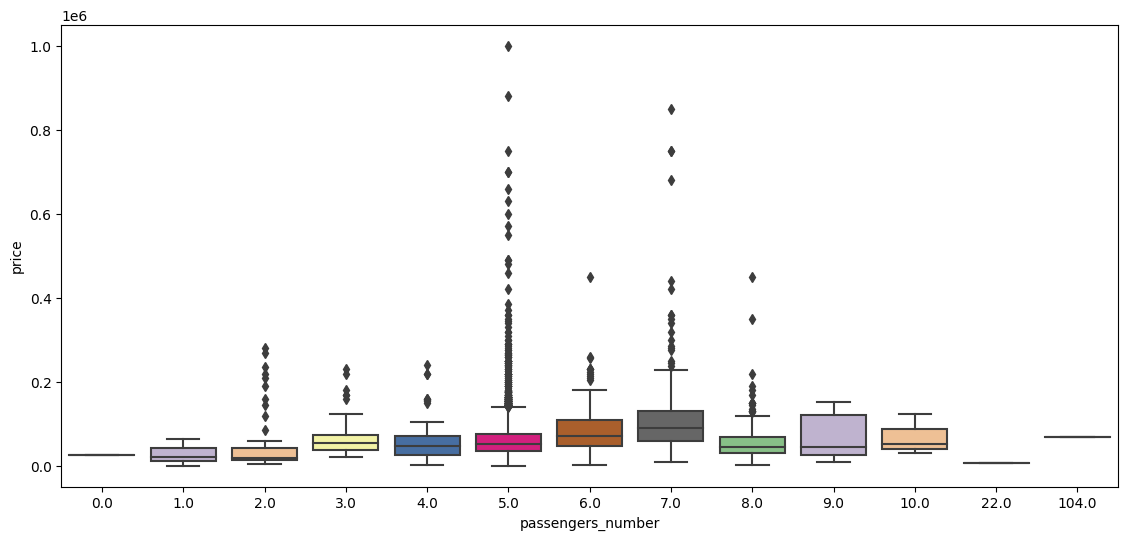

In [61]:
f= plt.figure(figsize=(30,6))
ax=f.add_subplot(121)
sns.boxplot(x = 'passengers_number', y = 'price', data = dataset,palette='Accent', ax=ax)

* difference in distributions of cars 

<AxesSubplot: xlabel='passengers_number', ylabel='count'>

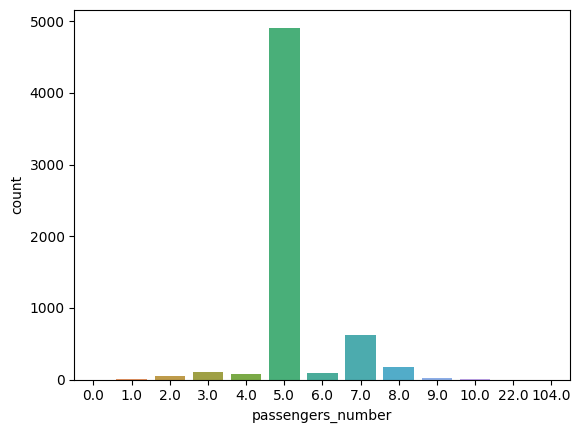

In [62]:
df=pd.DataFrame(dataset['passengers_number'].value_counts()).reset_index().rename(columns={'index':'passengers_number','passengers_number':'count'})
sns.barplot(x='passengers_number',y='count',data=df)

#### Visualising Numerical features

<AxesSubplot: ylabel='passengers_number'>

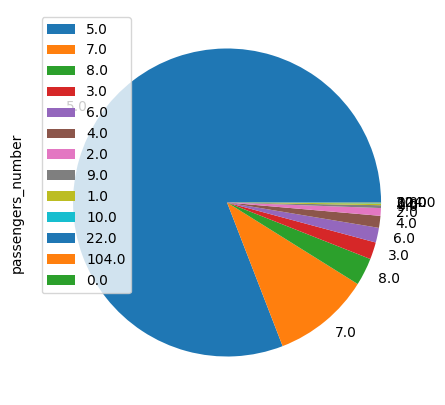

In [63]:
pd.DataFrame(dataset['passengers_number'].value_counts()).\
    plot.pie(y='passengers_number', figsize=(5, 5))

In [64]:
(0.05,) * 6

(0.05, 0.05, 0.05, 0.05, 0.05, 0.05)

<AxesSubplot: ylabel='car_type'>

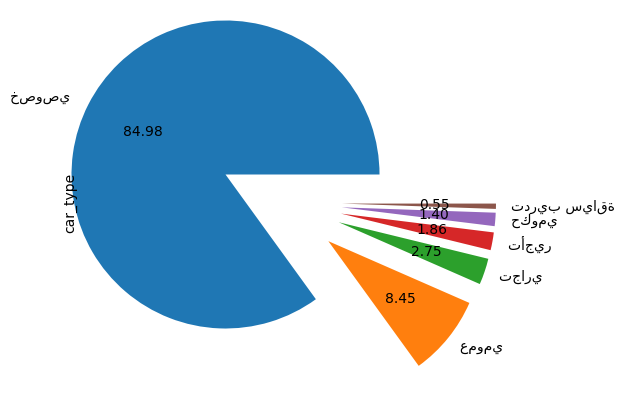

In [65]:
explode = (0.4,) * dataset['car_type'].nunique()

dataset['car_type'].value_counts().\
    plot.pie(autopct='%.2f', y='car_type', figsize=(5, 5), explode=explode)

<AxesSubplot: xlabel='passengers_number', ylabel='price'>

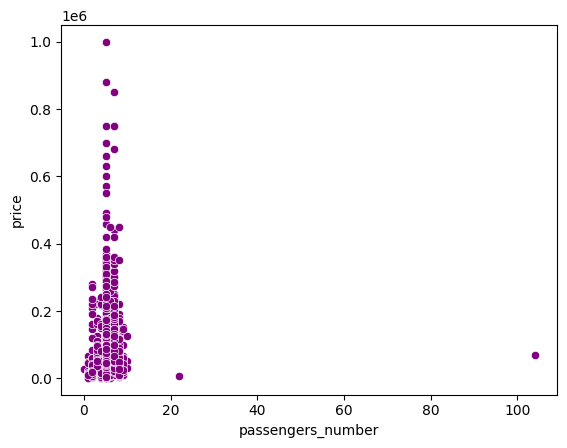

In [66]:
sns.scatterplot(x="passengers_number", y="price", data=dataset,color='purple')

* Observe having 2 outliers out of the range

In [67]:
dataset[dataset['passengers_number'] > 17]

,car_color,fuel_type,car_type,car_license,gear_type,windows,motor_power,speedometer,passengers_number,payment_method,car_state,ex_owners,additions,price
190,أبيض,ديزل,خصوصي,نمرة صفراء,عادي,يدوي,3000,2000,22.0,نقدا فقط,للبيع فقط,1.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\n\n,7000
694,بني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,78000,104.0,إمكانية التقسيط,للبيع أو التبديل,0.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,68000


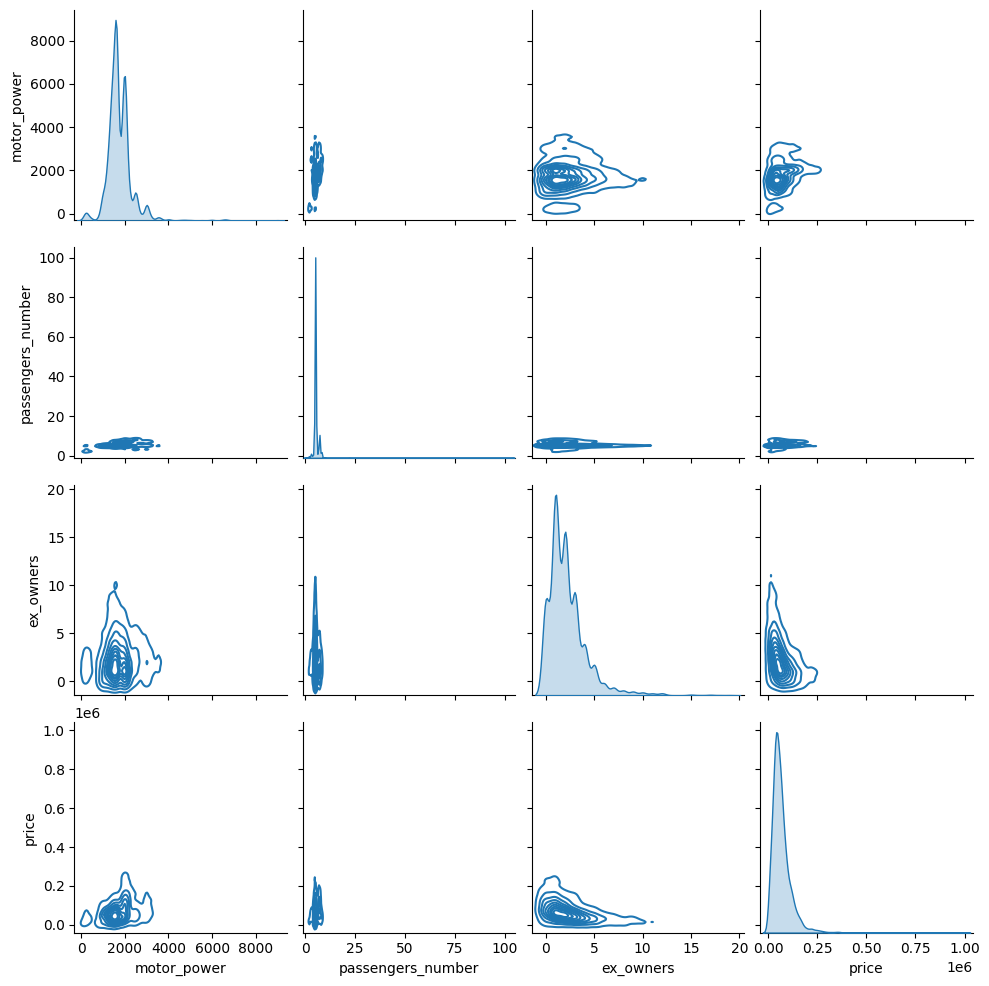

In [68]:
sns.pairplot(dataset[numeric_parameters_header], kind="kde")

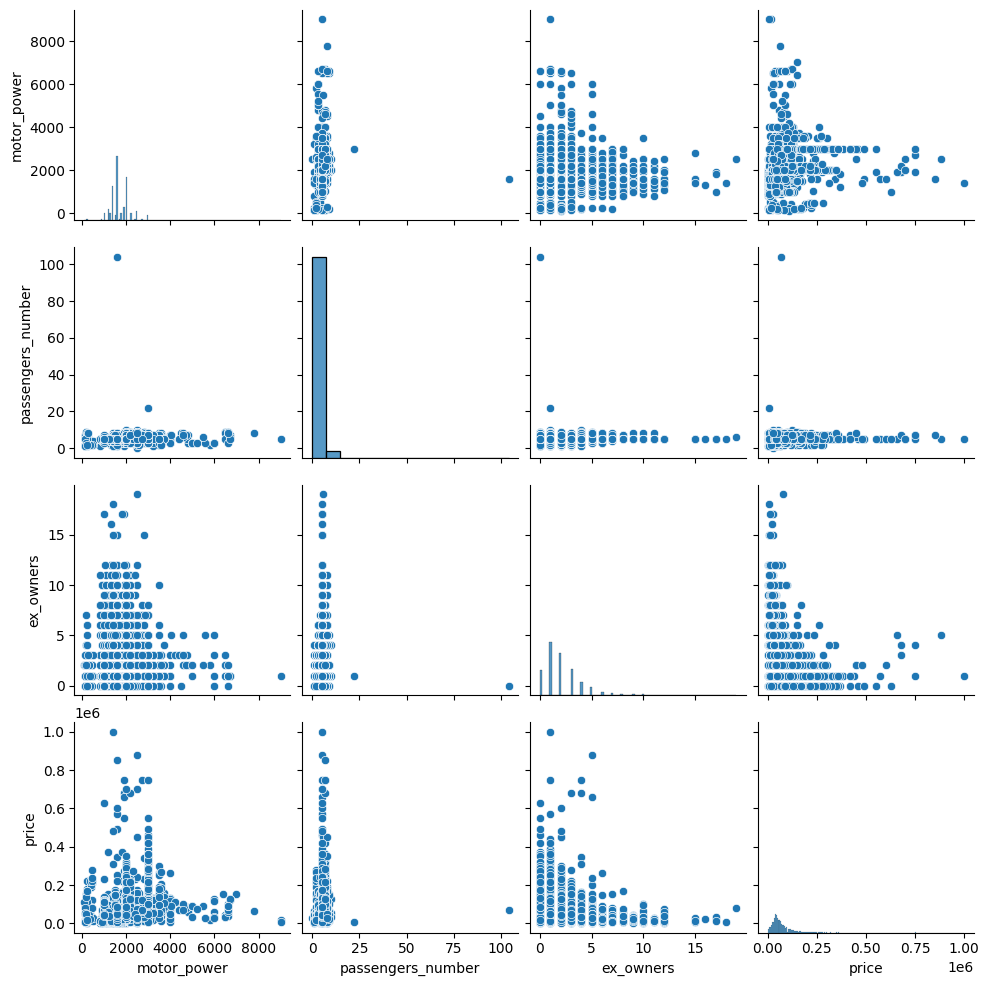

In [69]:
sns.pairplot(dataset[numeric_parameters_header])

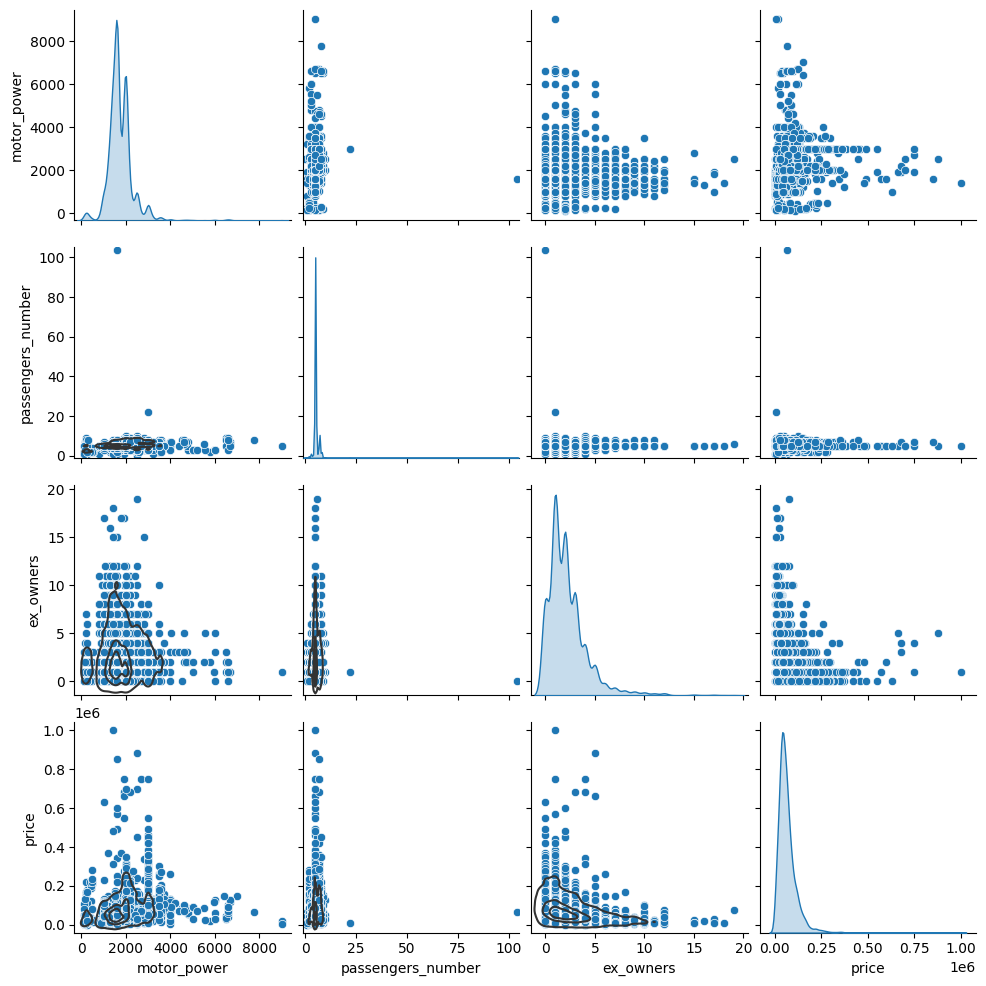

In [70]:
g = sns.pairplot(dataset[numeric_parameters_header], diag_kind="kde")
g.map_lower(sns.kdeplot, levels=4, color=".2")

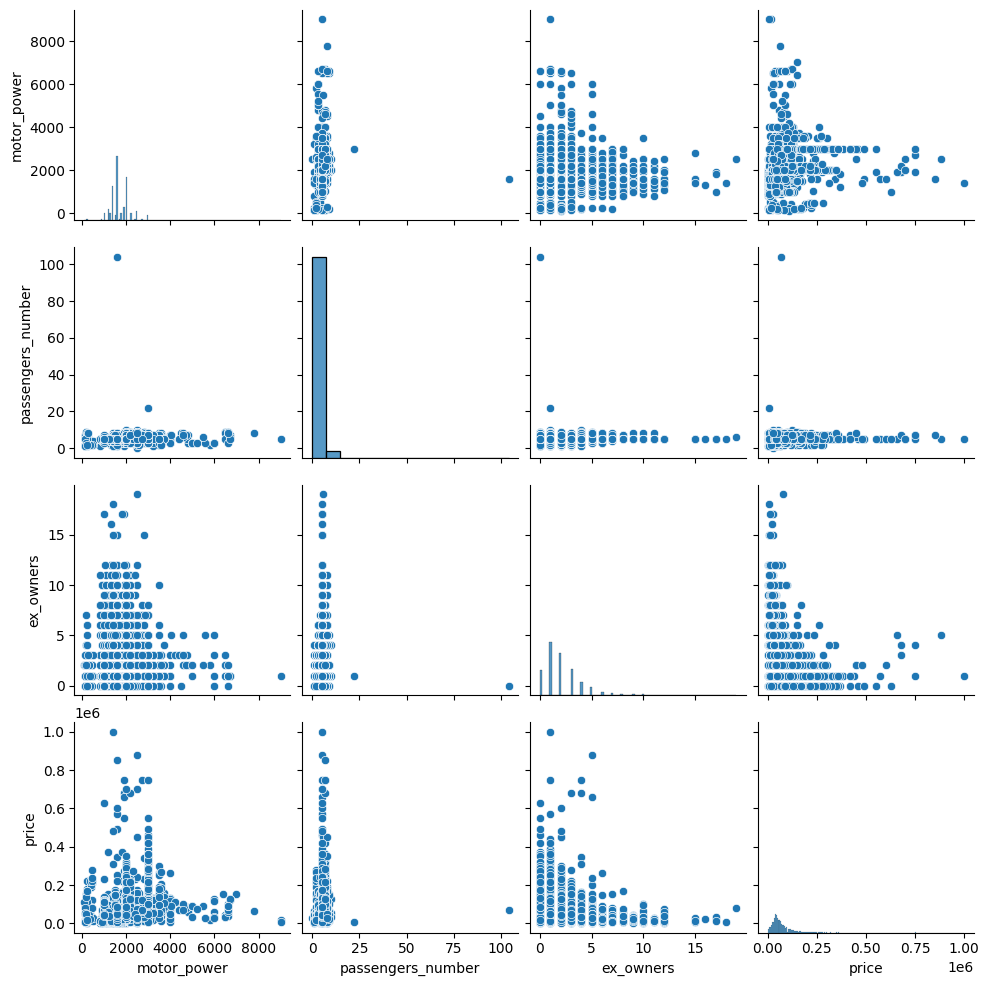

In [71]:
sns.pairplot(dataset[numeric_parameters_header])

In [72]:
numeric_data.corr()

,motor_power,passengers_number,ex_owners,price
motor_power,1.000000,0.183294,0.019108,0.236166
passengers_number,0.183294,1.000000,-0.033077,0.086970
ex_owners,0.019108,-0.033077,1.000000,-0.309354
price,0.236166,0.086970,-0.309354,1.000000


<AxesSubplot: >

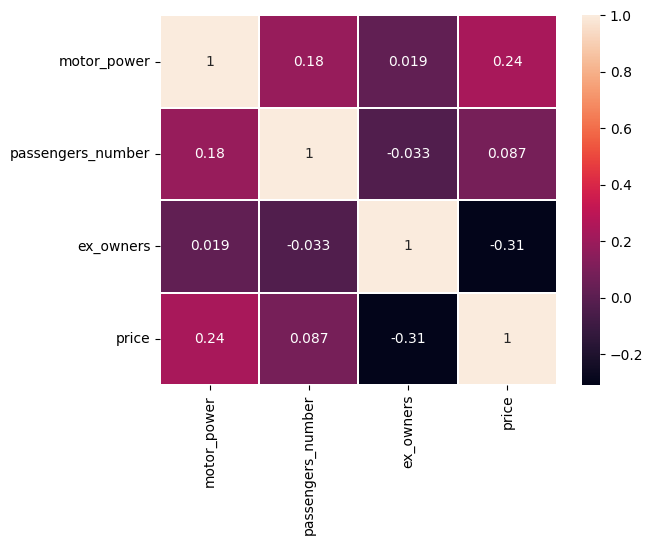

In [73]:
sns.heatmap(numeric_data.corr(), annot=True, linewidths=0.05)

* Observe the highest corelation with price is 'ex_owners'
* Other features have weak correlation with price, especially "passengers_number"